In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import classification_report, fbeta_score, confusion_matrix, precision_recall_curve, auc, make_scorer

In [2]:
accepted_loans = pd.read_csv('../input/elitedata/elite.csv')

In [3]:
X = accepted_loans.loc[:, accepted_loans.columns != 'loan_paid'].values
y = accepted_loans['loan_paid'].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

In [6]:
minmax_scaler = ('minmax', MinMaxScaler())

In [7]:
class_weights = [3.2, 3.6, 4.0]

In [8]:
svm = ('svm', SVC(random_state=42, cache_size=2000, max_iter=1500, class_weight='balanced'))
svm_param_grid = {
    'svm__C': [100, 10, 1.0, 0.1, 0.001],
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__class_weight': [{0: x, 1: 1.0} for x in class_weights]
}

In [9]:
# Metric
f_onehalf_scorer = make_scorer(fbeta_score, beta=0.5)

In [10]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=cv,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(3, 1, figsize=(15, 15))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        scoring=f_onehalf_scorer,
        return_times=True,
        random_state=42
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times") 
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [11]:
def plot_search_results(search):
    df = pd.DataFrame(search.cv_results_)
    results = ['mean_test_score',
            'mean_train_score',
            'std_test_score', 
            'std_train_score']

    fig, axes = plt.subplots(1, len(param_grid), 
                          figsize = (7*len(param_grid), 5),
                          sharey='row')
    if len(param_grid) == 1:
        axes = [axes]

    axes[0].set_ylabel("Score", fontsize=25)


    for idx, (param_name, param_range) in enumerate(param_grid.items()):
        try:
            grouped_df = df.groupby(f'param_{param_name}')[results]\
              .agg({'mean_train_score': 'mean',
                    'mean_test_score': 'mean',
                    'std_train_score': 'mean',
                    'std_test_score': 'mean'})

            previous_group = df.groupby(f'param_{param_name}')[results]
            axes[idx].set_xlabel(param_name, fontsize=30)
            axes[idx].set_ylim(0.0, 1.1)
            lw = 2
            axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                      color="darkorange", lw=lw)
            axes[idx].fill_between(param_range,grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                          grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                          color="darkorange", lw=lw)
            axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                      color="navy", lw=lw)
            axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                          grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                          color="navy", lw=lw)
        except:
            pass

    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle('Validation curves', fontsize=40)
    fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

    fig.subplots_adjust(bottom=0.25, top=0.85)  
    plt.show()

In [12]:
def print_result_df(search):
  keeping_columns = ['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'std_fit_time']
  df = pd.DataFrame(search.cv_results_)
  df = df[keeping_columns].sort_values(by='mean_test_score', ascending=False)
  return df.iloc[:10, :]

In [13]:
def print_best_model_result(search, name):
  print("Best parameter (CV score=):" % search.best_score_)
  best_model = search.best_estimator_
  print(best_model)

  y_pred = best_model.predict(X_test)

  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))
  
  f_onehalf_score = fbeta_score(y_test, y_pred, beta=0.5)
  print('f0.5_score=', f_onehalf_score)

  try :
    y_score = best_model.predict_proba(X_test)[:, 1]
    # calculate precision and recall for each threshold
    precision, recall, threshold = precision_recall_curve(y_test, y_score)
    # calculate scores
    pr_auc = auc(recall, precision)
    print('pr_auc_score=', pr_auc)

    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y_test[y_test==1]) / len(y_test)
    # plot the no skill precision-recall curve
    plt.figure(figsize=(10, 7))
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot the model precision-recall curve
    plt.plot(recall, precision, marker='.', label=name)
    plt.title(f'{name}(pr_auc={pr_auc})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
  except:
    pass

  return best_model

In [14]:
pipe = Pipeline(steps=[minmax_scaler, svm])

In [15]:
param_grid = svm_param_grid

In [16]:
search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=3, return_train_score=True)

In [17]:
search.fit(X_train, y_train)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 39803
max_resources_: 1074704
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 60
n_resources: 39803
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.835, test=0.843) total time=   7.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.761, test=0.761) total time=   6.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.844, test=0.847) total time=   7.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.818, test=0.816) total time=   6.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.836, test=0.837) total time=   6.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.868, test=0.867) total time=   8.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.841, test=0.841) total time=   8.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.867, test=0.866) total time=   7.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.863, test=0.859) total time=   8.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.863, test=0.861) total time=   8.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.862, test=0.854) total time=  10.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.877, test=0.879) total time=  12.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.864, test=0.864) total time=  10.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.854, test=0.850) total time=  11.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.878, test=0.868) total time=  11.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.811, test=0.814) total time=  10.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.819, test=0.821) total time=  10.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.828, test=0.829) total time=  10.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.827, test=0.825) total time=  10.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.821, test=0.823) total time=  10.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.837, test=0.835) total time=   6.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.816, test=0.813) total time=   6.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.860, test=0.866) total time=   7.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.846, test=0.841) total time=   5.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.861, test=0.864) total time=   6.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.867, test=0.865) total time=   8.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.866, test=0.867) total time=   8.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.853, test=0.849) total time=   9.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.871, test=0.864) total time=   8.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.866, test=0.865) total time=   9.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.863, test=0.859) total time=  10.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.863, test=0.860) total time=  10.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.856, test=0.856) total time=  10.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.862, test=0.853) total time=  10.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.877, test=0.868) total time=  10.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.814, test=0.817) total time=  10.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.774, test=0.775) total time=   9.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.825, test=0.824) total time=   9.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.820, test=0.821) total time=   9.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.822, test=0.824) total time=   9.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.808, test=0.808) total time=   6.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.815, test=0.817) total time=   5.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.851, test=0.848) total time=   6.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.878, test=0.871) total time=   6.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.849, test=0.854) total time=   6.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.861, test=0.862) total time=   8.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.876, test=0.876) total time=   8.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.866, test=0.866) total time=   7.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.871, test=0.865) total time=   8.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.866, test=0.863) total time=   8.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.832, test=0.833) total time=  10.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.868, test=0.862) total time=  10.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.849, test=0.845) total time=  10.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.822, test=0.818) total time=  10.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.865, test=0.866) total time=  11.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.747, test=0.742) total time=  11.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.360, test=0.364) total time=  11.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.702, test=0.699) total time=  11.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.666, test=0.660) total time=  11.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.495, test=0.481) total time=  11.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.823, test=0.821) total time=   7.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.878, test=0.878) total time=   7.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.841, test=0.841) total time=   8.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.872, test=0.864) total time=   7.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.861, test=0.860) total time=   8.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.896, test=0.893) total time=   9.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.881, test=0.878) total time=   9.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.885, test=0.879) total time=   9.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.897, test=0.893) total time=   9.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.888, test=0.885) total time=   9.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.864, test=0.865) total time=  10.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.879, test=0.880) total time=  11.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.891, test=0.889) total time=  11.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.862, test=0.857) total time=  10.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.895, test=0.892) total time=  11.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.819, test=0.823) total time=  10.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.826, test=0.830) total time=   9.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.798, test=0.804) total time=  10.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.814, test=0.810) total time=  10.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.821, test=0.826) total time=  10.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.856, test=0.856) total time=   8.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.876, test=0.879) total time=   8.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.861, test=0.857) total time=   8.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.889, test=0.882) total time=   8.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.863, test=0.861) total time=   7.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.891, test=0.885) total time=   9.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.889, test=0.886) total time=   9.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.895, test=0.892) total time=   9.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.894, test=0.888) total time=   9.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.884, test=0.876) total time=   9.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.872, test=0.871) total time=  10.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.876, test=0.869) total time=  11.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.877, test=0.873) total time=  10.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.873, test=0.866) total time=  11.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.897, test=0.896) total time=  11.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.828, test=0.832) total time=  10.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.820, test=0.823) total time=   9.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.818, test=0.820) total time=  10.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.823, test=0.821) total time=   9.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.825, test=0.826) total time=  10.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.849, test=0.848) total time=   8.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.870, test=0.871) total time=   8.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.870, test=0.869) total time=   7.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.872, test=0.870) total time=   7.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.844, test=0.845) total time=   8.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.884, test=0.880) total time=   9.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.844, test=0.838) total time=   9.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.875, test=0.870) total time=   9.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.892, test=0.886) total time=   9.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.884, test=0.878) total time=   9.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.854, test=0.855) total time=  11.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.889, test=0.888) total time=  11.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.885, test=0.884) total time=  11.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.854, test=0.846) total time=  11.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.854, test=0.848) total time=  11.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.426, test=0.424) total time=  12.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.519, test=0.506) total time=  11.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.711, test=0.708) total time=  11.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.587, test=0.591) total time=  11.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.304, test=0.310) total time=  11.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.856, test=0.859) total time=   8.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.878, test=0.878) total time=   8.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.861, test=0.867) total time=   9.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.892, test=0.886) total time=   8.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.902, test=0.902) total time=   8.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.777, test=0.778) total time=   8.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.794, test=0.791) total time=   8.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.789, test=0.789) total time=   8.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.752, test=0.754) total time=   8.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.801, test=0.793) total time=   8.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.756, test=0.762) total time=  10.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.805, test=0.804) total time=  10.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.807, test=0.808) total time=  10.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.823, test=0.817) total time=  10.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.802, test=0.794) total time=   9.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.786, test=0.787) total time=   9.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.756, test=0.756) total time=   9.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.784, test=0.794) total time=   9.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.783, test=0.785) total time=   9.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.771, test=0.773) total time=   9.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.862, test=0.861) total time=   8.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.877, test=0.879) total time=   8.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.894, test=0.890) total time=   7.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.854, test=0.848) total time=   8.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.876, test=0.875) total time=   8.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.764, test=0.769) total time=   8.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.767, test=0.762) total time=   8.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.783, test=0.782) total time=   8.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.801, test=0.797) total time=   8.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.745, test=0.732) total time=   8.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.798, test=0.803) total time=  10.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.826, test=0.828) total time=  10.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.843, test=0.840) total time=  10.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.789, test=0.782) total time=  11.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.832, test=0.823) total time=  10.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.767, test=0.769) total time=   9.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.744, test=0.737) total time=   9.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.790, test=0.801) total time=   9.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.757, test=0.755) total time=  10.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.766, test=0.771) total time=   9.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.854, test=0.854) total time=   8.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.827, test=0.829) total time=   8.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.842, test=0.838) total time=   8.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.859, test=0.855) total time=   9.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.839, test=0.832) total time=   8.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.634, test=0.634) total time=   8.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.715, test=0.710) total time=   9.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.685, test=0.675) total time=   9.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.683, test=0.684) total time=   8.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.721, test=0.710) total time=  10.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.713, test=0.722) total time=  11.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.696, test=0.690) total time=  10.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.755, test=0.750) total time=  10.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.750, test=0.743) total time=  10.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.700, test=0.688) total time=  11.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.659, test=0.667) total time=  11.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.715, test=0.709) total time=  11.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.704, test=0.700) total time=  11.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.773, test=0.774) total time=  11.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=1.0, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.737, test=0.739) total time=  11.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.903, test=0.903) total time=   7.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.854, test=0.856) total time=   7.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.910, test=0.906) total time=   7.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.896, test=0.890) total time=   7.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.885, test=0.885) total time=   7.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.331, test=0.335) total time=   8.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.325, test=0.315) total time=   8.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.348, test=0.332) total time=   7.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.375, test=0.368) total time=   7.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.383, test=0.365) total time=   8.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.527, test=0.523) total time=   9.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.491, test=0.489) total time=  10.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.452, test=0.448) total time=  10.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.774, test=0.771) total time=  10.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.437, test=0.428) total time=  10.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.833, test=0.836) total time=  12.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.847, test=0.852) total time=  11.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.841, test=0.843) total time=  10.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.836, test=0.836) total time=  11.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.837, test=0.839) total time=  10.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.859, test=0.861) total time=   7.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.851, test=0.853) total time=   7.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.896, test=0.891) total time=   7.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.897, test=0.890) total time=   7.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.895, test=0.892) total time=   8.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.425, test=0.433) total time=   8.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.345, test=0.346) total time=   8.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.291, test=0.276) total time=   8.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.342, test=0.341) total time=   8.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.223, test=0.207) total time=   7.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.259, test=0.265) total time=   9.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.341, test=0.332) total time=  10.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.448, test=0.442) total time=  10.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.522, test=0.521) total time=   9.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.458, test=0.447) total time=   9.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.850, test=0.853) total time=  10.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.853, test=0.853) total time=  10.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.849, test=0.855) total time=  10.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.844, test=0.844) total time=  10.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.839, test=0.842) total time=  10.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.655, test=0.666) total time=   8.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.673, test=0.671) total time=   8.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.680, test=0.677) total time=   8.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.688, test=0.684) total time=   7.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.673, test=0.661) total time=   7.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.039, test=0.035) total time=   8.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.118, test=0.097) total time=   8.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.019, test=0.012) total time=   8.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.151, test=0.142) total time=   9.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.060, test=0.064) total time=   9.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.006, test=0.006) total time=  10.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.074, test=0.070) total time=  10.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.015, test=0.014) total time=  10.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.033, test=0.030) total time=  11.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.020, test=0.015) total time=  10.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.265, test=0.263) total time=  11.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.239, test=0.223) total time=  11.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.347, test=0.355) total time=  11.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.183, test=0.171) total time=  11.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.207, test=0.201) total time=  11.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.833, test=0.835) total time=   7.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.153, test=0.128) total time=   7.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.834, test=0.836) total time=   7.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.832, test=0.831) total time=   7.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.832, test=0.837) total time=   8.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.000, test=0.000) total time=   8.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.000, test=0.000) total time=   8.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.000, test=0.000) total time=   8.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.000, test=0.000) total time=   9.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.000, test=0.000) total time=   8.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.000, test=0.000) total time=   9.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.000, test=0.000) total time=  10.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.000, test=0.000) total time=   9.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.000, test=0.000) total time=   9.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.000, test=0.000) total time=  10.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.833, test=0.835) total time=  11.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.833, test=0.836) total time=  10.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.834, test=0.836) total time=  11.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.832, test=0.831) total time=  11.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.001, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.832, test=0.837) total time=  10.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.833, test=0.835) total time=   7.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.000, test=0.000) total time=   7.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.834, test=0.836) total time=   7.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.832, test=0.831) total time=   8.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.832, test=0.837) total time=   8.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.000, test=0.000) total time=   8.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.000, test=0.000) total time=   8.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.000, test=0.000) total time=   8.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.000, test=0.000) total time=   8.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.000, test=0.000) total time=   8.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.000, test=0.000) total time=   9.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.000, test=0.000) total time=  10.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.000, test=0.000) total time=   9.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.000, test=0.000) total time=   9.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.000, test=0.000) total time=  10.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.833, test=0.835) total time=  10.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.833, test=0.836) total time=  10.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.834, test=0.836) total time=  10.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.832, test=0.831) total time=  10.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.001, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.832, test=0.837) total time=  10.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.000, test=0.000) total time=   8.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.000, test=0.000) total time=   7.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.000, test=0.000) total time=   7.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.000, test=0.000) total time=   8.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.000, test=0.000) total time=   7.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.000, test=0.000) total time=   8.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.000, test=0.000) total time=   8.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.000, test=0.000) total time=   8.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.000, test=0.000) total time=   8.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.000, test=0.000) total time=   8.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.000, test=0.000) total time=  10.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.000, test=0.000) total time=  10.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.000, test=0.000) total time=  10.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.000, test=0.000) total time=  10.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.000, test=0.000) total time=  10.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.000, test=0.000) total time=  11.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.000, test=0.000) total time=  11.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.000, test=0.000) total time=  11.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.000, test=0.000) total time=  11.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.001, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.000, test=0.000) total time=  11.6s
----------
iter: 1
n_candidates: 20
n_resources: 119409
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.828, test=0.826) total time=  39.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.775, test=0.771) total time=  38.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.818, test=0.815) total time=  39.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.740, test=0.736) total time=  38.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.764, test=0.768) total time=  37.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.834, test=0.832) total time=  35.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.841, test=0.838) total time=  34.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.841, test=0.840) total time=  34.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.841, test=0.841) total time=  38.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.834, test=0.835) total time=  36.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.825, test=0.826) total time=  34.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.872, test=0.869) total time=  36.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.809, test=0.807) total time=  35.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.855, test=0.858) total time=  31.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.814, test=0.813) total time=  36.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.845, test=0.845) total time=  41.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.825, test=0.819) total time=  42.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.836, test=0.833) total time=  36.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.730, test=0.733) total time=  39.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.832, test=0.831) total time=  41.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.767, test=0.768) total time=  44.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.817, test=0.818) total time=  46.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.759, test=0.754) total time=  44.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.847, test=0.847) total time=  46.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.808, test=0.808) total time=  44.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.810, test=0.811) total time=  37.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.840, test=0.835) total time=  37.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.831, test=0.833) total time=  37.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.797, test=0.798) total time=  37.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=linear;, score=(train=0.841, test=0.837) total time=  36.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.856, test=0.854) total time=  40.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.853, test=0.850) total time=  44.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.787, test=0.787) total time=  43.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.830, test=0.828) total time=  42.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.841, test=0.841) total time=  35.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.830, test=0.826) total time=  36.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.840, test=0.839) total time=  37.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.772, test=0.767) total time=  36.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.769, test=0.767) total time=  36.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.745, test=0.747) total time=  35.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.809, test=0.805) total time=  35.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.785, test=0.784) total time=  34.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.848, test=0.846) total time=  35.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.728, test=0.732) total time=  35.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=rbf;, score=(train=0.606, test=0.608) total time=  35.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.845, test=0.846) total time=  31.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.830, test=0.828) total time=  33.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.850, test=0.849) total time=  31.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.843, test=0.841) total time=  31.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.807, test=0.807) total time=  31.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.857, test=0.856) total time=  26.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.869, test=0.865) total time=  28.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.806, test=0.805) total time=  28.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.846, test=0.846) total time=  27.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.780, test=0.781) total time=  27.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.850, test=0.853) total time=  32.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.811, test=0.807) total time=  31.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.783, test=0.775) total time=  30.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.861, test=0.862) total time=  30.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.728, test=0.731) total time=  30.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.873, test=0.874) total time=  27.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.883, test=0.880) total time=  28.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.841, test=0.842) total time=  26.4s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.840, test=0.837) total time=  27.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.881, test=0.880) total time=  27.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.802, test=0.798) total time=  33.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.843, test=0.838) total time=  34.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.760, test=0.758) total time=  34.6s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.774, test=0.774) total time=  32.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=rbf;, score=(train=0.625, test=0.625) total time=  33.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.785, test=0.783) total time=  32.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.838, test=0.833) total time=  33.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.828, test=0.826) total time=  32.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.751, test=0.751) total time=  33.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=rbf;, score=(train=0.787, test=0.785) total time=  32.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.906, test=0.905) total time=  25.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.894, test=0.893) total time=  25.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.822, test=0.822) total time=  25.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.835, test=0.835) total time=  25.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.864, test=0.868) total time=  27.9s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.884, test=0.883) total time=  28.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.825, test=0.823) total time=  27.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.837, test=0.835) total time=  27.8s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.801, test=0.798) total time=  26.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=1.0, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.803, test=0.804) total time=  29.1s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.861, test=0.862) total time=  31.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.687, test=0.684) total time=  31.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.825, test=0.824) total time=  30.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.857, test=0.858) total time=  29.0s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=poly;, score=(train=0.731, test=0.722) total time=  30.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.829, test=0.829) total time=  30.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.855, test=0.853) total time=  30.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.775, test=0.775) total time=  30.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.843, test=0.846) total time=  31.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.796, test=0.794) total time=  30.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.894, test=0.894) total time=  25.7s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.861, test=0.855) total time=  25.5s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.872, test=0.871) total time=  26.3s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.834, test=0.834) total time=  25.2s


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.868, test=0.871) total time=  26.7s
----------
iter: 2
n_candidates: 7
n_resources: 358227
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.849, test=0.849) total time= 1.9min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.814, test=0.812) total time= 1.7min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.834, test=0.835) total time= 1.8min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.814, test=0.813) total time= 1.7min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=poly;, score=(train=0.826, test=0.826) total time= 1.8min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.814, test=0.813) total time= 1.7min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.820, test=0.819) total time= 1.8min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.758, test=0.757) total time= 1.8min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.808, test=0.808) total time= 1.8min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=100, svm__class_weight={0: 4.0, 1: 1.0}, svm__kernel=poly;, score=(train=0.805, test=0.807) total time= 1.8min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.803, test=0.802) total time= 1.4min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.826, test=0.827) total time= 1.4min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.716, test=0.716) total time= 1.4min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.841, test=0.840) total time= 1.5min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=10, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.822, test=0.821) total time= 1.4min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.841, test=0.840) total time= 1.7min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.836, test=0.834) total time= 1.6min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.835, test=0.833) total time= 1.7min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.831, test=0.830) total time= 1.8min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.833, test=0.833) total time= 1.6min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.818, test=0.819) total time= 1.4min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.825, test=0.823) total time= 1.4min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.790, test=0.789) total time= 1.4min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.821, test=0.819) total time= 1.4min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=1.0, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.843, test=0.842) total time= 1.3min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.834, test=0.833) total time= 1.3min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.890, test=0.888) total time= 1.3min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.817, test=0.817) total time= 1.4min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.843, test=0.843) total time= 1.3min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.845, test=0.844) total time= 1.3min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.834, test=0.833) total time= 1.3min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.834, test=0.833) total time= 1.3min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.868, test=0.868) total time= 1.3min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.838, test=0.837) total time= 1.3min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.835, test=0.835) total time= 1.3min
----------
iter: 3
n_candidates: 3
n_resources: 1074681
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.837, test=0.837) total time= 5.2min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.834, test=0.833) total time= 5.1min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.828, test=0.829) total time= 5.1min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.838, test=0.838) total time= 5.0min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=sigmoid;, score=(train=0.842, test=0.841) total time= 5.0min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.834, test=0.834) total time= 3.9min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.834, test=0.834) total time= 3.9min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.834, test=0.834) total time= 3.9min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.834, test=0.834) total time= 3.9min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 3.2, 1: 1.0}, svm__kernel=linear;, score=(train=0.834, test=0.834) total time= 4.0min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 1/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.834, test=0.834) total time= 3.9min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 2/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.834, test=0.834) total time= 4.0min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 3/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.834, test=0.834) total time= 3.9min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 4/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.834, test=0.834) total time= 4.0min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


[CV 5/5] END svm__C=0.1, svm__class_weight={0: 3.6, 1: 1.0}, svm__kernel=linear;, score=(train=0.875, test=0.876) total time= 3.9min


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=42),
                    estimator=Pipeline(steps=[('minmax', MinMaxScaler()),
                                              ('svm',
                                               SVC(cache_size=2000,
                                                   class_weight='balanced',
                                                   max_iter=1500,
                                                   random_state=42))]),
                    param_grid={'svm__C': [100, 10, 1.0, 0.1, 0.001],
                                'svm__class_weight': [{0: 3.2, 1: 1.0},
                                                      {0: 3.6, 1: 1.0},
                                                      {0: 4.0, 1: 1.0}],
                                'svm__kernel': ['linear', 'poly', 'rbf',
                                                'sigmoid']},
                    scoring=make_scorer(fbeta_score, beta=0.5), verbose=3)

In [18]:
print_result_df(search)

,params,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
36,"{'svm__C': 0.1, 'svm__class_weight': {0: 3.2, ...",0.889730,0.019498,0.887921,0.017702,6.506483,0.173380
17,"{'svm__C': 10, 'svm__class_weight': {0: 3.6, 1...",0.890645,0.003792,0.885392,0.005021,8.078184,0.148164
13,"{'svm__C': 10, 'svm__class_weight': {0: 3.2, 1...",0.889367,0.006180,0.885368,0.006411,8.176835,0.211782
24,"{'svm__C': 1.0, 'svm__class_weight': {0: 3.2, ...",0.877798,0.017406,0.878353,0.015030,7.254258,0.424882
40,"{'svm__C': 0.1, 'svm__class_weight': {0: 3.6, ...",0.879807,0.020102,0.877280,0.016744,6.608001,0.531003
14,"{'svm__C': 10, 'svm__class_weight': {0: 3.2, 1...",0.878301,0.013393,0.876554,0.013541,8.642717,0.202355
18,"{'svm__C': 10, 'svm__class_weight': {0: 3.6, 1...",0.879098,0.009296,0.874985,0.010565,8.732560,0.454282
28,"{'svm__C': 1.0, 'svm__class_weight': {0: 3.6, ...",0.872559,0.013508,0.870540,0.014595,7.155117,0.233821
21,"{'svm__C': 10, 'svm__class_weight': {0: 4.0, 1...",0.875941,0.016981,0.870466,0.016997,8.126930,0.207969
16,"{'svm__C': 10, 'svm__class_weight': {0: 3.6, 1...",0.869057,0.011699,0.866815,0.011137,7.078947,0.267433


In [19]:
print_best_model_result(search, 'MinMaxScaler + Tuning class weight + Tuning Logistic')

Best parameter (CV score=):
Pipeline(steps=[('minmax', MinMaxScaler()),
                ('svm',
                 SVC(C=0.1, cache_size=2000, class_weight={0: 3.6, 1: 1.0},
                     kernel='linear', max_iter=1500, random_state=42))])
              precision    recall  f1-score   support

           0       0.79      0.05      0.09     53638
           1       0.81      1.00      0.89    215038

    accuracy                           0.81    268676
   macro avg       0.80      0.52      0.49    268676
weighted avg       0.80      0.81      0.73    268676

[[  2551  51087]
 [   681 214357]]
f0.5_score= 0.8394214035873665


Pipeline(steps=[('minmax', MinMaxScaler()),
                ('svm',
                 SVC(C=0.1, cache_size=2000, class_weight={0: 3.6, 1: 1.0},
                     kernel='linear', max_iter=1500, random_state=42))])

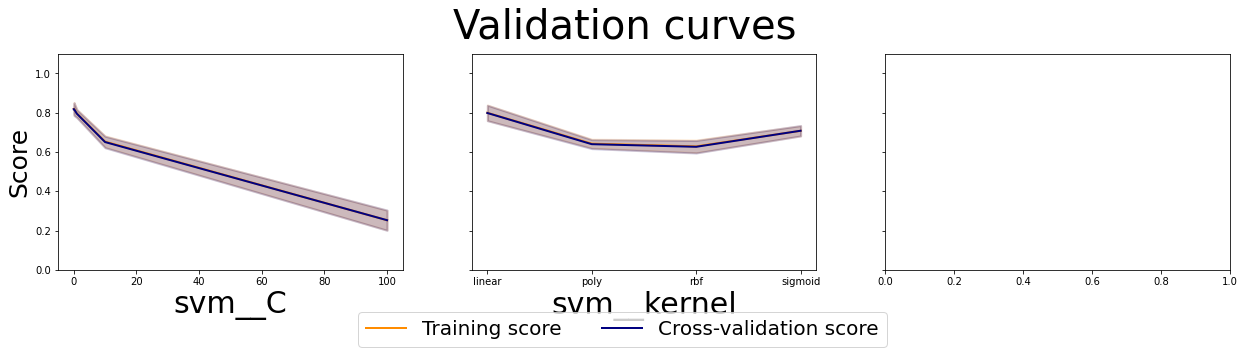

In [20]:
plot_search_results(search)

In [21]:
plot_learning_curve(search.best_estimator_, 'MinMaxScaler + Tuning class weight + Tuning Logistic', X_train, y_train, cv=cv, n_jobs=-1)
plt.show()